In [2]:
import kagglehub as kh
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam 
import joblib

In [3]:
# Download dataset
path = kh.dataset_download("sudalairajkumar/cryptocurrencypricehistory")

# Load Bitcoin data
df = pd.read_csv(os.path.join(path, 'coin_Bitcoin.csv'))

# Parse dates and sort data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Select relevant columns and convert to numerical type
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df_numeric = df[['Open', 'High', 'Low', 'Close']].astype(float)
df_numeric.dropna(inplace=True)

In [4]:
# Remove outliers
z_scores = np.abs(stats.zscore(df_numeric))
df_numeric = df_numeric[(z_scores < 3).all(axis=1)]
df = df.iloc[df_numeric.index]

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df['EMA'] = df['Close'].ewm(span=20, adjust=False).mean()
df['BOLL_UPPER'] = df['MA21'] + (df['Close'].rolling(window=21).std() * 2)
df['BOLL_LOWER'] = df['MA21'] - (df['Close'].rolling(window=21).std() * 2)
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df.dropna(inplace=True)

In [5]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'MA7', 'MA21', 'RSI']])

# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i, 3])  # Use 'Close' price as the target
    return np.array(X), np.array(y)

n_steps = 90
X, y = create_sequences(scaled_data, n_steps)

# Split into training and testing sets
train_size = int(len(X) * 0.6)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

2025-04-17 15:25:01.183138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 15:25:01.185639: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
53/53 [==============================] - 6s 69ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 2/10
53/53 [==============================] - 3s 59ms/step - loss: 3.5157e-04 - val_loss: 0.0042
Epoch 3/10
53/53 [==============================] - 3s 60ms/step - loss: 4.6876e-04 - val_loss: 0.0027
Epoch 4/10
53/53 [==============================] - 3s 64ms/step - loss: 4.1048e-04 - val_loss: 0.0035
Epoch 5/10
53/53 [==============================] - 3s 62ms/step - loss: 2.9724e-04 - val_loss: 0.0038
Epoch 6/10
53/53 [==============================] - 3s 63ms/step - loss: 3.7093e-04 - val_loss: 0.0027
Epoch 7/10
53/53 [==============================] - 3s 60ms/step - loss: 2.8548e-04 - val_loss: 0.0034
Epoch 8/10
53/53 [==============================] - 3s 56ms/step - loss: 2.4216e-04 - val_loss: 0.0029
Epoch 9/10
53/53 [==============================] - 3s 55ms/step - loss: 2.3542e-04 - val_loss: 0.0023
Epoch 10/10
53/53 [==============================] - 3s 55ms/step - loss: 2.5

In [47]:
# Predict on the test set
y_pred = model.predict(X_test)

# Reverse scaling
predicted_prices = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), scaled_data.shape[1] - 1)), y_pred], axis=1))
actual_prices = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices[:, -1], predicted_prices[:, -1]))

# Calculate accuracy
tolerance = 0.02
accurate_predictions = np.abs(predicted_prices[:, -1] - actual_prices[:, -1]) <= (tolerance * actual_prices[:, -1])
accuracy = np.mean(accurate_predictions) * 100

print(f"Model RMSE: {rmse:.4f}")
print(f"Model Accuracy: {accuracy:.2f}%")

35/35 [==============================] - 1s 15ms/step
Model RMSE: 4.0600
Model Accuracy: 47.57%


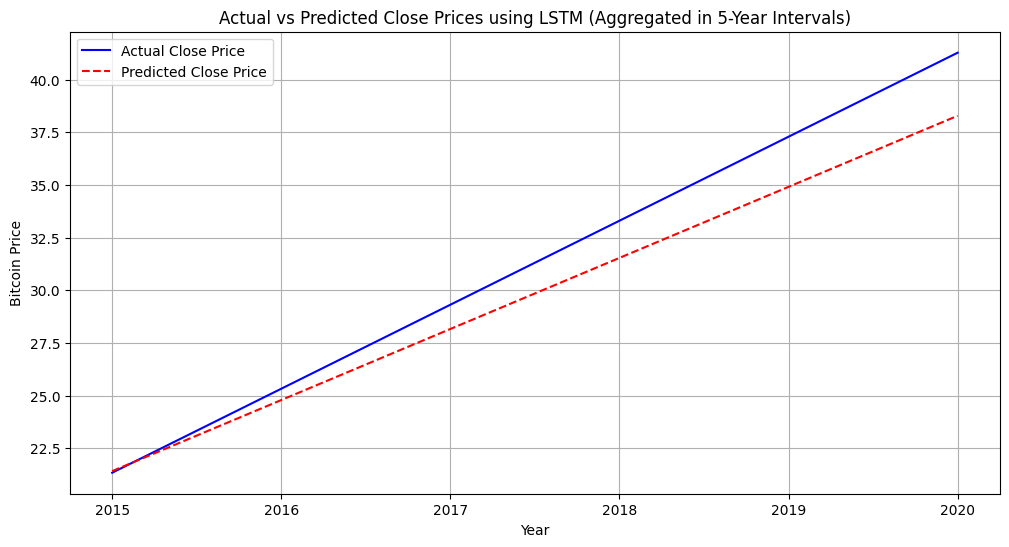

In [49]:
# Prepare data for five-year aggregation
df_test = df.iloc[-len(actual_prices):].copy()
df_test['Year'] = df_test['Date'].dt.year

# Bin years into five-year intervals
df_test['FiveYearInterval'] = (df_test['Year'] // 5) * 5

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'FiveYearInterval': df_test['FiveYearInterval'].values,
    'Actual': actual_prices[:, -1],
    'Predicted': predicted_prices[:, -1]
})

# Aggregate data by five-year intervals
plot_df = plot_df.groupby('FiveYearInterval').mean().reset_index()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(plot_df['FiveYearInterval'], plot_df['Actual'], label='Actual Close Price', color='blue')
plt.plot(plot_df['FiveYearInterval'], plot_df['Predicted'], label='Predicted Close Price', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Close Prices using LSTM (Aggregated in 5-Year Intervals)')
plt.xlabel('Year')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid()
plt.show()
